✅ Using Qiskit AerSimulator backend.

🔹 Running Phase Estimation: 3 counting qubits, θ = 0.25


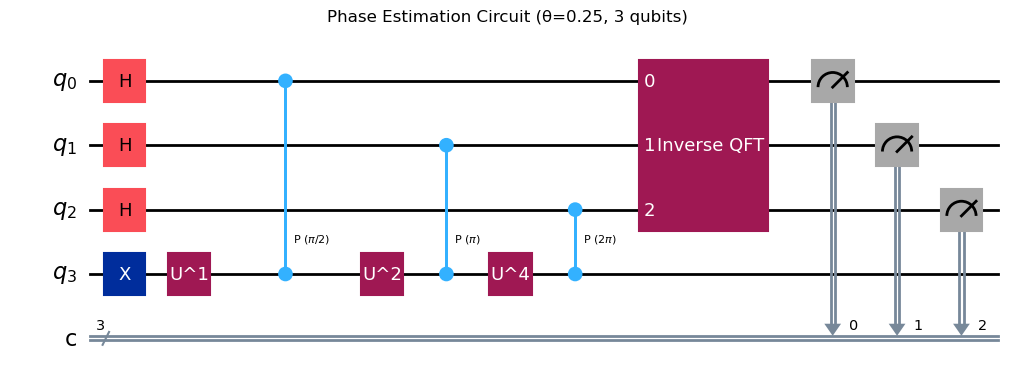

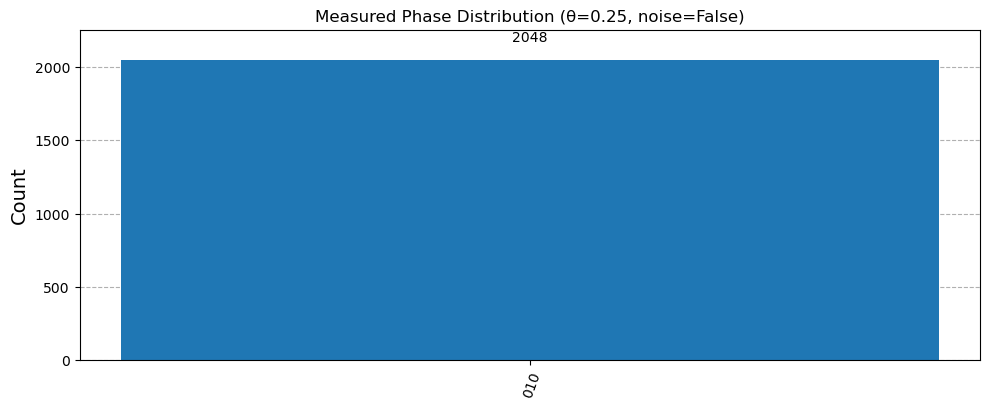

Expected binary: 010  (decimal: 2.000)
Most probable measured state: 010

🔹 Running Phase Estimation: 3 counting qubits, θ = 0.375


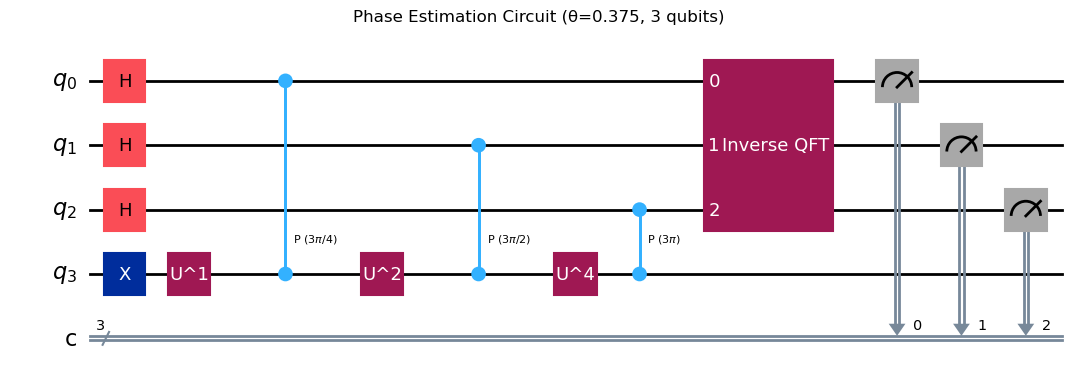

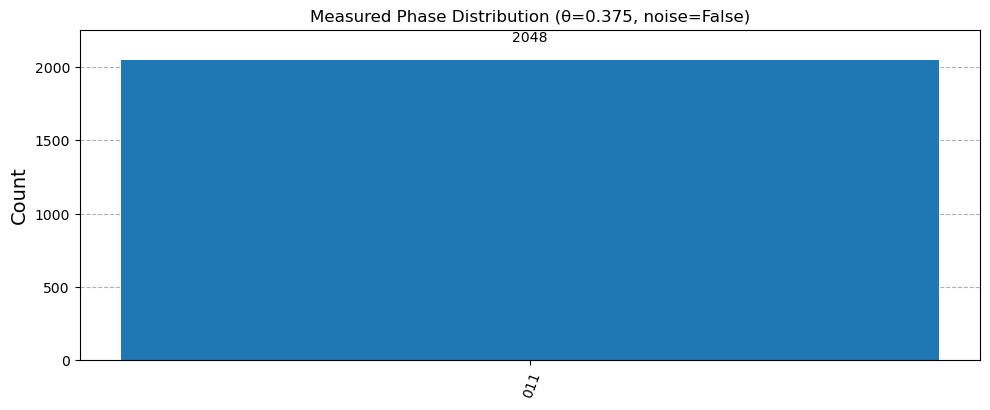

Expected binary: 011  (decimal: 3.000)
Most probable measured state: 011

🔹 Running Phase Estimation: 4 counting qubits, θ = 0.5


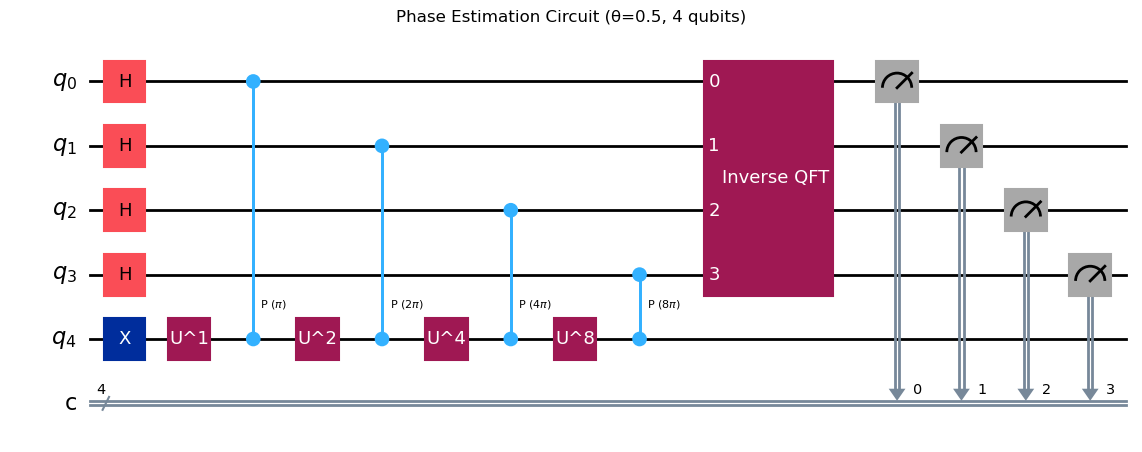

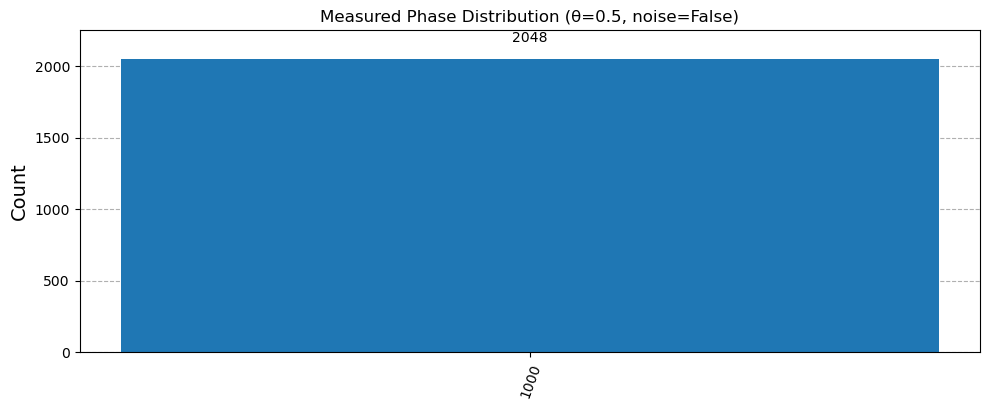

Expected binary: 1000  (decimal: 8.000)
Most probable measured state: 1000

🔹 Running Phase Estimation: 5 counting qubits, θ = 0.375


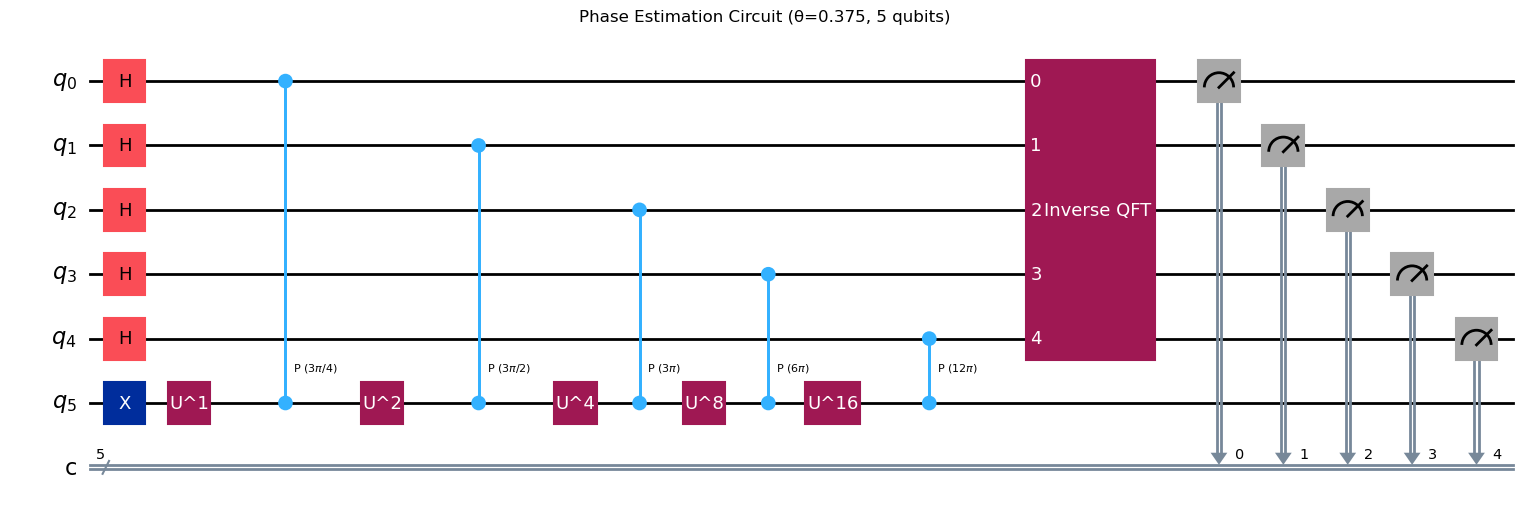

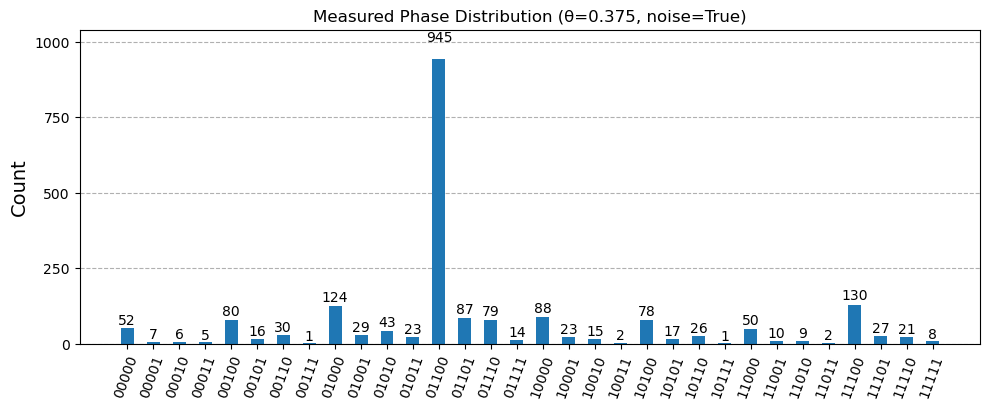

Expected binary: 01100  (decimal: 12.000)
Most probable measured state: 01100


In [10]:
# ==========================================================
# Quantum Phase Estimation — Fixed Noise Model for Qiskit ≥ 2.1
# ==========================================================

import numpy as np
from math import pi
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFTGate
from qiskit.quantum_info import Operator

# ==========================================================
# Backend Setup
# ==========================================================
try:
    from qiskit_aer import AerSimulator
    from qiskit_aer.noise import NoiseModel, depolarizing_error
    AER_AVAILABLE = True
    print("✅ Using Qiskit AerSimulator backend.")
except Exception:
    from qiskit.primitives import Sampler
    AER_AVAILABLE = False
    print("⚠️ Qiskit Aer not found — using Sampler (no noise simulation).")

# ==========================================================
# Run Helper
# ==========================================================
def run_counts(qc, shots=2048, noise=False):
    """Simulate the circuit and return measurement counts."""
    if AER_AVAILABLE:
        if noise:
            # ✅ Proper noise for both 1-qubit and 2-qubit ops
            noise_model = NoiseModel()
            noise_1q = depolarizing_error(0.01, 1)
            noise_2q = depolarizing_error(0.03, 2)
            noise_model.add_all_qubit_quantum_error(noise_1q, ['u', 'rz', 'rx', 'ry', 'id'])
            noise_model.add_all_qubit_quantum_error(noise_2q, ['cx'])
            backend = AerSimulator(noise_model=noise_model)
        else:
            backend = AerSimulator()
        qc_copy = qc.copy()
        transpiled = transpile(qc_copy, backend)
        result = backend.run(transpiled, shots=shots).result()
        return result.get_counts()
    else:
        from qiskit.primitives import Sampler
        sampler = Sampler()
        qc.measure_all()
        job = sampler.run([qc])
        result = job.result()
        quasi = result[0].data["quasi_dists"][0]
        counts = {format(k, f"0{qc.num_clbits}b"): int(v * shots) for k, v in enumerate(quasi.values())}
        return counts

# ==========================================================
# Inverse QFT
# ==========================================================
def build_inverse_qft(n):
    """Return the inverse QFT circuit on n qubits."""
    iqft = QuantumCircuit(n, name="Inverse QFT")
    qft_gate = QFTGate(n)
    iqft.append(qft_gate.inverse(), range(n))
    return iqft

# ==========================================================
# Phase Estimation Circuit
# ==========================================================
def build_phase_estimation(count_qubits, phi):
    total = count_qubits + 1
    qc = QuantumCircuit(total, count_qubits)
    qc.h(range(count_qubits))
    qc.x(total - 1)

    # Controlled-U^2^j gates
    for j in range(count_qubits):
        power = 2 ** j
        U_phi = np.array([[1, 0], [0, np.exp(2j * pi * phi * power)]])
        qc.unitary(U_phi, [total - 1], label=f"U^{power}")
        qc.cp(2 * pi * phi * power, j, total - 1)

    # Add inverse QFT
    iqft = build_inverse_qft(count_qubits)
    qc.append(iqft.to_instruction(), range(count_qubits))

    # Measurement
    qc.measure(range(count_qubits), range(count_qubits))
    return qc

# ==========================================================
# Demonstration
# ==========================================================
def demo_phase_estimation(count_qubits=3, phi=0.25, shots=2048, noise=False):
    print(f"\n🔹 Running Phase Estimation: {count_qubits} counting qubits, θ = {phi}")
    qc = build_phase_estimation(count_qubits, phi)

    # Show circuit diagram
    qc.draw('mpl', fold=150)
    plt.title(f"Phase Estimation Circuit (θ={phi}, {count_qubits} qubits)")
    plt.show()

    # Run simulation
    counts = run_counts(qc, shots=shots, noise=noise)
    plot_histogram(counts)
    plt.title(f"Measured Phase Distribution (θ={phi}, noise={noise})")
    plt.show()

    # Compare results
    expected_decimal = phi * (2 ** count_qubits)
    expected_binary = format(int(round(expected_decimal)) % (2 ** count_qubits), f'0{count_qubits}b')
    measured = max(counts, key=counts.get)
    print(f"Expected binary: {expected_binary}  (decimal: {expected_decimal:.3f})")
    print(f"Most probable measured state: {measured}")

# ==========================================================
# Run All Experiments
# ==========================================================
demo_phase_estimation(count_qubits=3, phi=0.25)
demo_phase_estimation(count_qubits=3, phi=0.375)
demo_phase_estimation(count_qubits=4, phi=0.5)
demo_phase_estimation(count_qubits=5, phi=0.375, noise=True)
